In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [2]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [3]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [16]:
coordinates, elements3, dirichlet, neumann = maillage(10)

In [18]:
Nt = len(elements3)
M = np.zeros((3,3))
Ns = len(coordinates)
A = np.zeros((Ns,Ns))
b_tp = np.zeros(3)
b = np.zeros(Ns)
Nd = len(dirichlet)
A_bis = np.zeros((Nd,Nd))
Uk = np.zeros(Ns)
Uk[dirichlet] = 5
u = Uk
for i in range(Nt):
    Tp = elements3[i]
    x1 = coordinates[Tp[0]][0]
    x2 = coordinates[Tp[1]][0]
    x3 = coordinates[Tp[2]][0]
    y1 = coordinates[Tp[0]][1]
    y2 = coordinates[Tp[1]][1]
    y3 = coordinates[Tp[2]][1]
    alpha =(x2-x1)*(y3-y1)-(y2-y1)*(x3-x1)
    g_n1 = [y2-y3, x3-x2]/alpha
    g_n2 = [y3-y1, x1-x3]/alpha
    g_n3 = [y1-y2, x2-x1]/alpha
    aire = alpha/2
    M[0,0]= aire*np.dot(g_n1, g_n1)
    M[0,1]= aire*np.dot(g_n1, g_n2)
    M[0,2]= aire*np.dot(g_n1, g_n3)
    M[1,0]= aire*np.dot(g_n2, g_n1) 
    M[1,1]= aire*np.dot(g_n2, g_n2)
    M[1,2]= aire*np.dot(g_n2, g_n3)    
    M[2,0]= aire*np.dot(g_n3, g_n1)    
    M[2,1]= aire*np.dot(g_n3, g_n2)
    M[2,2]= aire*np.dot(g_n3, g_n3)

    A[Tp, Tp[0]] = A[Tp, Tp[0]] + M[:,0]
    A[Tp, Tp[1]] = A[Tp, Tp[1]] + M[:,1]
    A[Tp, Tp[2]] = A[Tp, Tp[2]] + M[:,2]

    xg = (x1 + x2 +x3)/3
    yg = (y1 + y2 +y3)/3

    b_tp[0] = alpha*f(xg,yg)/6
    b_tp[1] = alpha*f(xg,yg)/6
    b_tp[2] = alpha*f(xg,yg)/6

    b[Tp] = b[Tp] + b_tp

b = b - np.dot(A,Uk)

masque = np.ones(Ns, dtype=bool)
masque[dirichlet] = False 
x = np.linalg.solve(A[np.ix_(masque, masque)], b[masque])
u[masque] = x

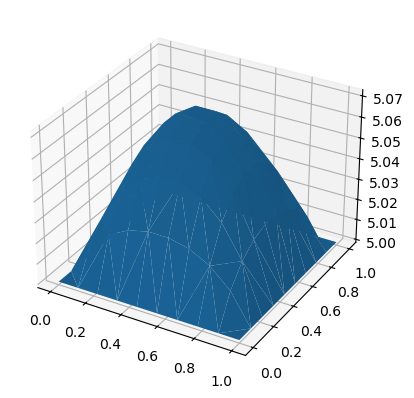

In [19]:
show(coordinates,u)

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [93]:
def f(x,y):
    return 1

In [142]:
def g(x,y):
    return 1

In [143]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int) #dirichlet
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int) #liste des arretes neumann
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.], #sommet 
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

In [144]:
Nt = len(e3)
M3 = np.zeros((3,3))

Nq = len(e4)
M4 = np.zeros((4,4))

Ns = len(ccs)
A = np.zeros((Ns,Ns))

b3_tp = np.zeros(3)
b4_tq = np.zeros(4)
b = np.zeros(Ns)

Nd = len(dds)
Uk = np.zeros(Ns)
Uk[dds] = 1
u = Uk

for i in range(Nt):
    Tp = e3[i]
    x1 = ccs[Tp[0]][0]
    x2 = ccs[Tp[1]][0]
    x3 = ccs[Tp[2]][0]
    y1 = ccs[Tp[0]][1]
    y2 = ccs[Tp[1]][1]
    y3 = ccs[Tp[2]][1]
    alpha =(x2-x1)*(y3-y1)-(y2-y1)*(x3-x1)
    g_n1 = [y2-y3, x3-x2]/alpha
    g_n2 = [y3-y1, x1-x3]/alpha
    g_n3 = [y1-y2, x2-x1]/alpha
    aire = alpha/2
    M3[0,0]= aire*np.dot(g_n1, g_n1)
    M3[0,1]= aire*np.dot(g_n1, g_n2)
    M3[0,2]= aire*np.dot(g_n1, g_n3)
    M3[1,0]= aire*np.dot(g_n2, g_n1) 
    M3[1,1]= aire*np.dot(g_n2, g_n2)
    M3[1,2]= aire*np.dot(g_n2, g_n3)    
    M3[2,0]= aire*np.dot(g_n3, g_n1)    
    M3[2,1]= aire*np.dot(g_n3, g_n2)
    M3[2,2]= aire*np.dot(g_n3, g_n3)

    A[Tp, Tp[0]] = A[Tp, Tp[0]] + M3[:,0]
    A[Tp, Tp[1]] = A[Tp, Tp[1]] + M3[:,1]
    A[Tp, Tp[2]] = A[Tp, Tp[2]] + M3[:,2]

    xg = (x1 + x2 +x3)/3
    yg = (y1 + y2 +y3)/3

    b3_tp[0] = alpha*f(xg,yg)/6
    b3_tp[1] = alpha*f(xg,yg)/6
    b3_tp[2] = alpha*f(xg,yg)/6

    b[Tp] = b[Tp] + b3_tp

print(Tp)
# print(b)

for i in range(Nq):
    Tq = e4[i]
    x1 = ccs[Tq[0]][0]
    x2 = ccs[Tq[1]][0]
    x3 = ccs[Tq[2]][0]
    x4 = ccs[Tq[3]][0]
    y1 = ccs[Tq[0]][1]
    y2 = ccs[Tq[1]][1]
    y3 = ccs[Tq[2]][1]
    y4 = ccs[Tq[3]][1]

    J = np.array([[x2-x1, y2-y1],[x4-x1, y4-y1]])
    inv = np.linalg.inv(np.dot(J.T, J))
    a = inv[0,0]
    b_cons = inv[0,1]
    c = inv[1,1]
    
    # x = np.array([x1, x2, x3, x4])
    # y = np.array([y1, y2, y3, y4])
    # aire_q = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    aire_q = np.linalg.det(J)

    alpha =(x2-x1)*(y3-y1)-(y2-y1)*(x3-x1)

    
    M4[0,0] = aire_q * (a/3 + c/3 + b_cons/2)
    M4[0,1] = aire_q * (-a/3 + c/6)
    M4[1,0] = aire_q * (-a/3 + c/6)
    M4[0,2] = aire_q * (-a/6 - c/6 - b_cons/2)
    M4[2,0] = aire_q * (-a/6 - c/6 - b_cons/2)
    M4[0,3] = aire_q * (a/6 - c/3)
    M4[3,0] = aire_q * (a/6 - c/3)   
    M4[1,1] = aire_q * (a/3 + c/3 - b_cons/2)
    M4[1,2] = aire_q * (a/6 - c/3)
    M4[2,1] = aire_q * (a/6 - c/3)
    
    M4[1,3] = aire_q * (-a/6 - c/6 + b_cons/2)
    M4[3,1] = aire_q * (-a/6 - c/6 + b_cons/2)
    
    M4[2,2] = aire_q * (a/3 + c/3 + b_cons/2)
    
    M4[2,3] = aire_q * (-a/3 + c/6)
    M4[3,2] = aire_q * (-a/3 + c/6)
    
    M4[3,3] = aire_q * (a/3 + c/3 - b_cons/2)

    A[Tq, Tq[0]] = A[Tq, Tq[0]] + M4[:,0]
    A[Tq, Tq[1]] = A[Tq, Tq[1]] + M4[:,1]
    A[Tq, Tq[2]] = A[Tq, Tq[2]] + M4[:,2]
    A[Tq, Tq[3]] = A[Tq, Tq[3]] + M4[:,3]


    xg = (x1 + x2 +x3 + x4)/4
    yg = (y1 + y2 + y3 + y4)/4

    
    b4_tq[0] = alpha*f(xg,yg)/4
    b4_tq[1] = alpha*f(xg,yg)/4
    b4_tq[2] = alpha*f(xg,yg)/4
    b4_tq[3] = alpha*f(xg,yg)/4


    b[Tq] = b[Tq] + b4_tq

# print(A)

for a in nns:
    a1 = a[0]
    a2 = a[1]
    l = np.sqrt((ccs[a1][0] - ccs[a2][0])**2 + (ccs[a1][1] - ccs[a2][1])**2)
    milieu = np.array([(ccs[a1][0] + ccs[a2][0])/2, (ccs[a1][1] + ccs[a2][1])/2])
    b[a1] = b[a1] + l*g(milieu[0], milieu[1])/2
    b[a2] = b[a2] + l*g(milieu[0], milieu[1])/2
    

b = b - np.dot(A,Uk)

masque = np.ones(Ns, dtype=bool)
masque[dds] = False 
x = np.linalg.solve(A[np.ix_(masque, masque)], b[masque])
u[masque] = x

[ 3 15  4]


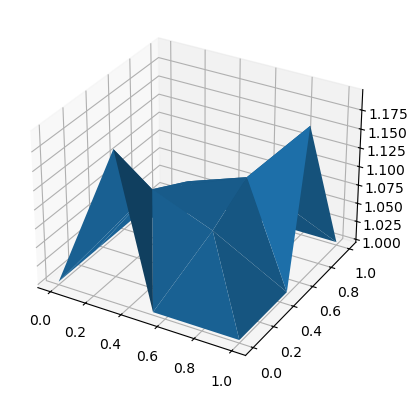

In [147]:
show(ccs,u)

In [84]:
# A[masque]

In [116]:
u

array([0.        , 0.04095517, 0.        , 0.06453064, 0.        ,
       0.040389  , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.07463662, 0.06836718, 0.07443685,
       0.        ])